## AIM: Create a simple GAN in PyTorch to generate synthetic sine wave data. Plot the results using MatPlotLib.

# Generative Adversarial Networks (GANs)

**Generative Adversarial Networks (GANs)** are a class of machine learning models designed for generating new data that mimics the distribution of a given dataset. GANs consist of two neural networks: a **Generator (G)** and a **Discriminator (D)**.

## Components

1. **Generator (G)**:
   - Learns to map random noise from a latent space to data resembling the target distribution.
   - Objective: Generate data that "fools" the discriminator into classifying it as real.

2. **Discriminator (D)**:
   - Learns to distinguish between real data from the dataset and fake data generated by the generator.
   - Objective: Maximize classification accuracy between real and fake data.

## Applications
* Image generation
* Data augmentation
* Text-to-image generation
* Music and speech synthesis

### Importing Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

### Defining Sin(x) function

In [2]:
def sine_function(x):
    return torch.sin(x)

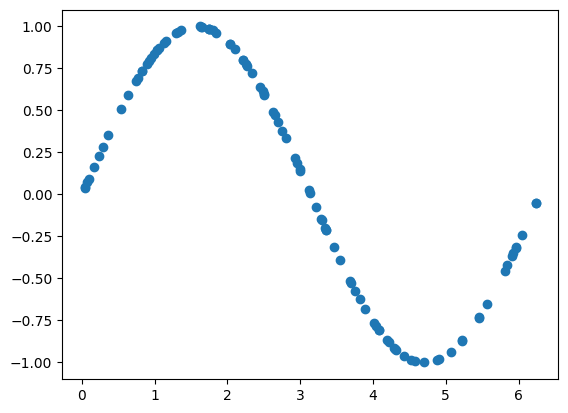

In [3]:
x = torch.rand(100) * 2 * torch.pi
y = sine_function(x)
plt.scatter(x.numpy(), y.numpy())
plt.show()

### Generating Data Samples based on Sin(x) function

In [4]:
def generate_data_samples(n=100):
    x1 = torch.rand(n) * 2 * torch.pi
    x2 = sine_function(x1)
    x1 = x1.view(n, 1)
    x2 = x2.view(n, 1)
    y_data = torch.ones((n, 1))
    return torch.hstack((x1, x2)), y_data

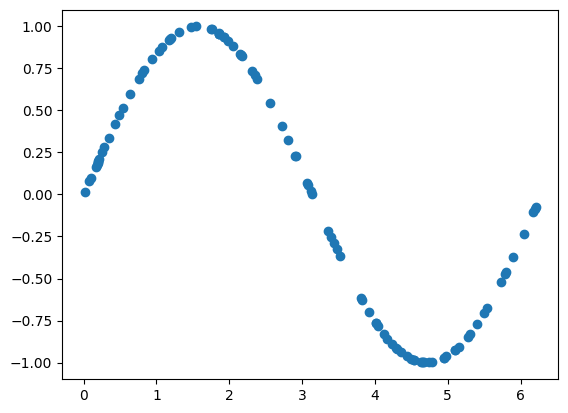

In [5]:
test_generated_data = generate_data_samples(100)
plt.scatter(test_generated_data[0][:, 0].numpy(), test_generated_data[0][:, 1].numpy())
plt.show()

### Generating random data samples

In [6]:
def generate_dummy_fake_data(n):
    x1 = torch.rand(n) * 2 * torch.pi
    x2 = torch.rand(n) * 2 * torch.pi
    x1 = x1.view(n, 1)
    x2 = x2.view(n, 1)
    y_fake = torch.zeros((n, 1))
    return torch.hstack((x1, x2)), y_fake

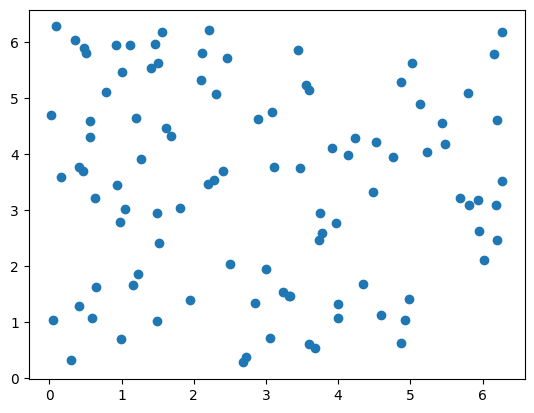

In [7]:
fake_data = generate_dummy_fake_data(100)
plt.scatter(fake_data[0][:, 0].numpy(), fake_data[0][:, 1].numpy())
plt.show()

### Defining Model Architecture for GANs

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(5, 15)
        self.fc2 = nn.Linear(15, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(2, 25)
        self.fc2 = nn.Linear(25, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

### Training the Discriminator

In [10]:
# Initialization

discriminator = Discriminator()
x_data_test = torch.rand(2)
discriminator(x_data_test)

tensor([0.4691], grad_fn=<SigmoidBackward0>)

In [11]:
# Defining optimizer and loss function

optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [12]:
epochs = 100
n = 100
x_data, y_data = generate_data_samples(n)
x_fake, y_fake = generate_dummy_fake_data(n)

x_all = torch.vstack((x_data, x_fake))
y_all = torch.vstack((y_data, y_fake))
all_loss = []
for i in range(epochs):
    y_hat = discriminator(x_all)
    loss = criterion(y_hat, y_all)
    all_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

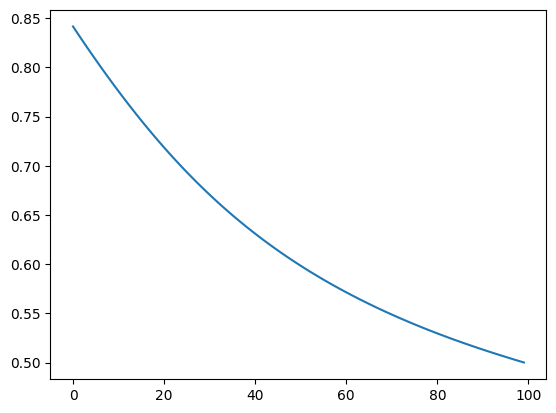

In [13]:
plt.plot(all_loss)
plt.show()

### Training the Generator

In [14]:
# Initialization

generator = Generator()
test_generator = generator(torch.rand(5))
print(test_generator)

tensor([-0.0216, -0.0230], grad_fn=<ViewBackward0>)


In [15]:
# Generating random noise to feed into the generator

def generate_latent_points(n, latent_dim=5):
    z = torch.rand(n * latent_dim)
    return z.view((n, latent_dim))

# Testing and printing the function
a = generate_latent_points(10)
print(a)

tensor([[0.0453, 0.7284, 0.6714, 0.2040, 0.8813],
        [0.9423, 0.5618, 0.7390, 0.6190, 0.1692],
        [0.5278, 0.0570, 0.5482, 0.2331, 0.6147],
        [0.4287, 0.0012, 0.8272, 0.4944, 0.2546],
        [0.1349, 0.0206, 0.9028, 0.3389, 0.6754],
        [0.9067, 0.6218, 0.5804, 0.4836, 0.0060],
        [0.3015, 0.5748, 0.0705, 0.8447, 0.5061],
        [0.9001, 0.9725, 0.7412, 0.4579, 0.0379],
        [0.6675, 0.9798, 0.6877, 0.9308, 0.2174],
        [0.9471, 0.7462, 0.3234, 0.2817, 0.5273]])


In [16]:
training_steps = 200000
generator = Generator()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

loss = nn.BCELoss()
N = 128

for i in range(training_steps):
    generator_optimizer.zero_grad()
    if i % 5000 == 0:
        print(f"{i}\n")
    fake_data = generator(generate_latent_points(N))
    fake_data_labels = torch.ones((N, 1))
    real_data, real_data_labels = generate_data_samples(N)
    generator_loss = loss(discriminator(fake_data), fake_data_labels)
    generator_loss.backward()
    generator_optimizer.step()

    discriminator_optimizer.zero_grad()
    real_loss = loss(discriminator(real_data), real_data_labels)
    fake_loss = loss(discriminator(fake_data.detach()), torch.zeros((N, 1)))
    discriminator_loss = (real_loss + fake_loss) / 2
    discriminator_loss.backward()
    discriminator_optimizer.step()


0

5000

10000

15000

20000

25000

30000

35000

40000

45000

50000

55000

60000

65000

70000

75000

80000

85000

90000

95000

100000

105000

110000

115000

120000

125000

130000

135000

140000

145000

150000

155000

160000

165000

170000

175000

180000

185000

190000

195000



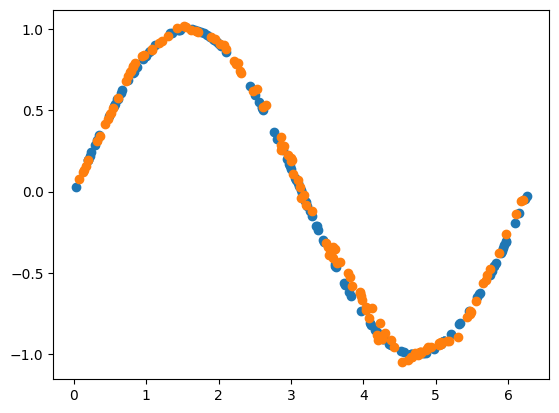

In [17]:
plt.scatter(real_data[:, 0].detach().numpy(), real_data[:, 1].detach().numpy())
plt.scatter(fake_data[:, 0].detach().numpy(), fake_data[:, 1].detach().numpy())
plt.show()